In [49]:
import os
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
tf.config.list_physical_devices('GPU')

import matplotlib.pyplot as plt
import glob


from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns


In [50]:
from tqdm import tqdm

### Data loading

In [ ]:
# import shutil
# import random

# ran_list = random.sample(range(0, 2094),2094-1152)
# print(len(ran_list))

# child_file_list = []
# c_path = '/Users/kimmonica/Documents/alexia/speech seg/dataset/CHILD/'
# save = '/Users/kimmonica/Desktop/CHILD_2/'
# for num, i in enumerate(ran_list):
#     try:
#         num =str(i)
#         img = c_path+'CHILD_2child_'+num+'.png'
#         print(img)
#         shutil.move(img, save + 'child_{}.png'.format(i))
#     except:
#         pass


In [78]:
import splitfolders
folder_path = '/Users/kimmonica/Documents/alexia/speech seg/dataset'
splitfolders.ratio(folder_path, output = folder_path, seed =77, ratio=(0.8, 0.2))

Copying files: 2326 files [00:01, 1587.98 files/s]


In [79]:
from sklearn.preprocessing import label_binarize
categories = ['adult', 'child']

In [80]:
folder_path = '/Users/kimmonica/Documents/alexia/speech seg/dataset/'
# SIZE = 128  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in tqdm (glob.glob(folder_path+'train/*')):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        # img = cv2.resize(img, (SIZE, SIZE))
        if img.shape != (369, 251, 3):
            pass
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            train_images.append(img)
            train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(len(train_images))

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

1850


In [81]:
folder_path = '/Users/kimmonica/Documents/alexia/speech seg/dataset/'
# SIZE = 128  #Resize images

#Capture training data and labels into respective lists
test_images = []
test_labels = [] 

for directory_path in tqdm (glob.glob(folder_path+'val/*')):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        # img = cv2.resize(img, (SIZE, SIZE))
        if img.shape != (369, 251, 3):
            pass
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            test_images.append(img)
            test_labels.append(label)

#Convert lists to arrays        
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(len(test_images))

100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

466


### model work

In [82]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#딥러닝으로 들어갈때는 원핫으로 들어가야함

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [83]:
from keras.applications.vgg16 import VGG16

#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(369, 251, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 369, 251, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 369, 251, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 369, 251, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 184, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 184, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 184, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 62, 128)       0     

In [84]:
print(x_train.shape)

(1850, 369, 251, 3)


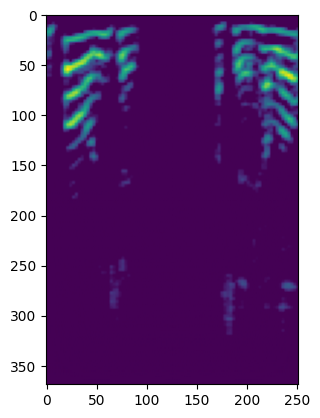

In [85]:
plt.imshow(x_train[0])

In [86]:
x_train[1].shape

(369, 251, 3)

In [87]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train = features #This is our X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_train, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
# print(prediction_RF)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
# print(prediction_RF)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

15/15 [==============================] - 5s 324ms/step
Accuracy =  0.9763948497854077


              precision    recall  f1-score   support

       ADULT       0.98      0.97      0.98       231
       CHILD       0.97      0.98      0.98       235

    accuracy                           0.98       466
   macro avg       0.98      0.98      0.98       466
weighted avg       0.98      0.98      0.98       466



<Axes: >

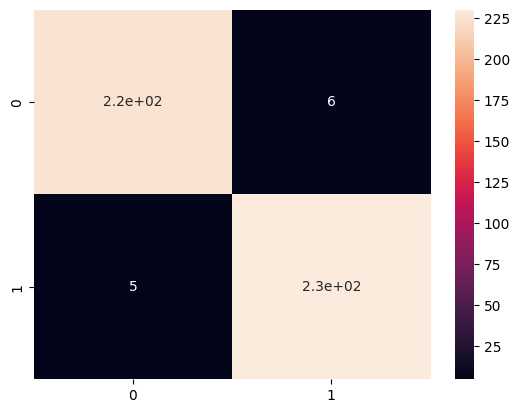

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
report = classification_report(test_labels, prediction_RF)
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
print(report)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 16ms/step
The prediction for this image is:  ['ADULT']
The actual label for this image is:  ADULT


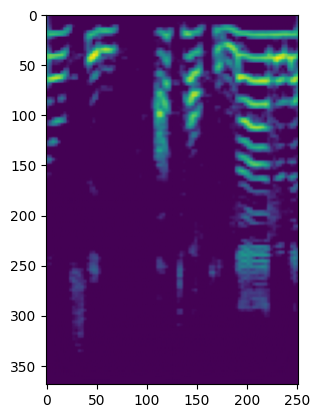

In [105]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

In [106]:
import joblib
joblib.dump(RF_model, '230625_RF_model_98.pkl')


['230625_RF_model_98.pkl']

### Model Evaluation

In [107]:
#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [108]:
y_score = RF_model.fit(X_train, y_train).predict_proba(X_test_features)
y_score

array([[0.98, 0.02],
       [0.76, 0.24],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.7 , 0.3 ],
       [0.96, 0.04],
       [0.88, 0.12],
       [0.78, 0.22],
       [0.92, 0.08],
       [0.9 , 0.1 ],
       [0.94, 0.06],
       [0.84, 0.16],
       [0.98, 0.02],
       [0.68, 0.32],
       [0.82, 0.18],
       [0.58, 0.42],
       [0.82, 0.18],
       [0.9 , 0.1 ],
       [0.88, 0.12],
       [0.86, 0.14],
       [0.94, 0.06],
       [0.84, 0.16],
       [0.8 , 0.2 ],
       [0.78, 0.22],
       [0.92, 0.08],
       [0.56, 0.44],
       [0.44, 0.56],
       [0.82, 0.18],
       [0.9 , 0.1 ],
       [0.86, 0.14],
       [0.98, 0.02],
       [0.74, 0.26],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.92, 0.08],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.94, 0.06],
       [0.72, 0.28],
       [0.96, 0.04],
       [0.68, 0.32],
       [0.72, 0.28],
       [0.96, 0.04],
       [0.7 , 0.3 ],
       [0.82, 0.18],
       [0.2 ,

In [109]:
y = label_binarize(test_labels_encoded, classes=[0, 1])
y[0]

array([0])

In [110]:
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [111]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

/var/folders/8q/qvkg_x054xg6wpd18ns2jgp40000gn/T/ipykernel_48767/3321945849.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


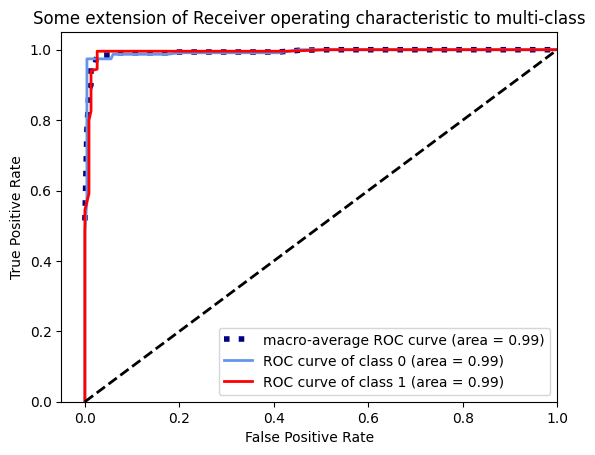

In [112]:
#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'red', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


### VIDEO test

In [113]:
import librosa
import librosa.display
from IPython.display import Audio, display

In [114]:
voice_path = '/Users/kimmonica/Documents/alexia/test_aud1.m4a'

In [115]:
y, sr = librosa.load('/Users/kimmonica/Documents/alexia/test_aud1.m4a')
display(Audio(y, rate=sr))

/var/folders/8q/qvkg_x054xg6wpd18ns2jgp40000gn/T/ipykernel_48767/358849249.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load('/Users/kimmonica/Documents/alexia/test_aud1.m4a')
/Users/kimmonica/miniforge3/envs/tensorflow_mac/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


### making imput data

In [116]:
def audio_input(audio_file_path, sec):

    start_point_list = []
    end_point_list = []
    S_db_mel_list = []
    y, sr = librosa.load(audio_file_path)
    duration = int(np.trunc(librosa.get_duration(y=y, sr=sr)))
   
    start = []
    for i  in range(0,duration):
        if i % sec ==0:
            start.append(i)
    end = start[1:]
    
    for num, i in enumerate(start):
        try:
            start_point = sr*start[num]
            start_point_list.append(int(start_point/sr))
            end_point = sr*end[num]
            end_point_list.append(int(end_point/sr))
            ny = y[start_point: end_point]
            # display(Audio(ny, rate=sr))

            S = librosa.feature.melspectrogram(y=ny, sr = sr, n_mels =128)
            S_db_mel = librosa.amplitude_to_db(S,  ref = np.max)
            # img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log')            
            S_db_mel_list.append(S_db_mel)
        except:
            end_point =sr*duration
            end_point_list.append(int(end_point/sr))
            ny = y[start_point: end_point]
            # display(Audio(ny, rate=sr))

            S = librosa.feature.melspectrogram(y=ny, sr = sr, n_mels =128)
            S_db_mel = librosa.amplitude_to_db(S,  ref = np.max)
            S_db_mel_list.append(S_db_mel)

        # train_images_list=np.array(S_db_mel_list)

        
    return S_db_mel_list 

In [102]:
S_db_mel_list = audio_input(voice_path, 2)

/var/folders/8q/qvkg_x054xg6wpd18ns2jgp40000gn/T/ipykernel_48767/1926586573.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)


In [103]:
from tqdm import tqdm

12it [00:01, 10.98it/s]


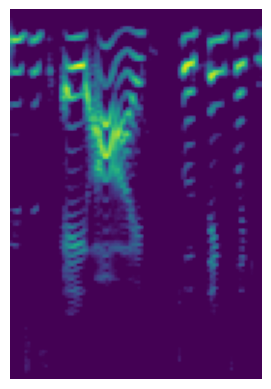

In [104]:
for num, i in tqdm(enumerate(S_db_mel_list)):
    plt.imshow(i)
    plt.axis('off')
    # plt.show()
    plt.savefig('test_folder/test_{}.png'.format(num), bbox_inches='tight',pad_inches = 0)

### 몰라 그냥 테스트

In [ ]:
test_folder_path = '/Users/kimmonica/Documents/alexia/speech seg/test_folder'

test_list = []

for i in os.listdir(test_folder_path):
    img = cv2.imread(test_folder_path+'/'+i, cv2.IMREAD_COLOR)
    try:
        if img.shape != (369, 251, 3):
            pass
        else:
            test_list.append(img)
    except:
        pass

final_test = np.array(test_list)
final_img_list = final_test/255.0
print(len(final_img_list))

12


In [ ]:
from keras.applications.vgg16 import VGG16

#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(369, 251, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 369, 251, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 369, 251, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 369, 251, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 184, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 184, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 184, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 62, 128)       0     

In [ ]:
import joblib
model = joblib.load('/Users/kimmonica/Documents/alexia/speech seg/230625_RF_model_98.pkl')

In [ ]:
#Now, let us use features from convolutional network for RF
input_img_feature=VGG_model.predict(final_img_list)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this VOICE is: ", prediction_RF)

1/1 [==============================] - 0s 18ms/step
The prediction for this VOICE is:  ['CHILD']


In [ ]:
for i in model.predict(input_img_features):
    print(i)

1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
def audio_slicer(audio_file_path, sec, save_path):

    start_point_list = []
    end_point_list = []
    S_db_mel_list = []
    y, sr = librosa.load(audio_file_path)
    duration = int(np.trunc(librosa.get_duration(y=y, sr=sr)))
   
    start = []
    for i  in range(0,duration):
        if i % sec ==0:
            start.append(i)
    end = start[1:]
    
    for num, i in enumerate(start):
        try:
            start_point = sr*start[num]
            start_point_list.append(int(start_point/sr))
            end_point = sr*end[num]
            end_point_list.append(int(end_point/sr))
            ny = y[start_point: end_point]
            print(num)
            display(Audio(ny, rate=sr))
            # sf.write(save_path+'{}.wav'.format(num), ny, sr ,'PCM_24')
            
        except:
            end_point =sr*duration
            end_point_list.append(int(end_point/sr))
            ny = y[start_point: end_point]
            print(num)
            display(Audio(ny, rate=sr))
            # librosa.output.write_wav('/Users/kimmonica/Documents/alexia/speech seg/test_aud_folder/{}.wav'.format(num), ny, sr)
            # sf.write(save_path+'{}.wav'.format(num), ny, sr ,'PCM_24')
# 

In [ ]:
import soundfile as sf

In [ ]:
save_path = '/Users/kimmonica/Documents/alexia/speech seg/test_aud_folder/'
audio_slicer(voice_path, 2,save_path )

0


/var/folders/8q/qvkg_x054xg6wpd18ns2jgp40000gn/T/ipykernel_48767/1310330588.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)
/Users/kimmonica/miniforge3/envs/tensorflow_mac/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1


2


3


4


5


6


7


8


9


10


11
